<a href="https://colab.research.google.com/github/Jelli36/Predicting-constructiveness-of-Steam-Game-Reviews/blob/main/Steam_Reviews_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [3]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
import PIL
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import linear_model, naive_bayes, ensemble, tree, svm, model_selection,\
                    preprocessing, feature_extraction, metrics, base, pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML/steam_reviews_constructiveness_1.5k.csv")
display(df)

,id,game,review,author_playtime_at_review,voted_up,votes_up,votes_funny,constructive
0,1,Among Us,This game can suck my balls before I play it a...,6,False,1,0,0
1,2,Among Us,Very fun little party game! Even better with f...,11,True,0,0,1
2,3,Among Us,if you're lonely don't bother but if you're no...,40,True,2,1,0
3,4,Among Us,fun and anoyying,80,True,0,0,0
4,5,Among Us,when impostor is sus...,51,True,0,0,0
...,...,...,...,...,...,...,...,...
1456,1457,Tom Clancy's Rainbow Six Siege,Good. Been better in the past.,857,True,0,0,0
1457,1458,Tom Clancy's Rainbow Six Siege,Great game but man the community is full of 12...,2,True,0,0,0
1458,1459,Tom Clancy's Rainbow Six Siege,I like smashing skulls in with a sledge hammer,71,True,0,0,0
1459,1460,Tom Clancy's Rainbow Six Siege,why do i die,78,True,0,0,0


#Cleaning

In [6]:
df.drop(columns='id', axis = 1, inplace = True) # Drop column id

In [7]:
df.isnull().sum() # Check for null values

,0
game,0
review,0
author_playtime_at_review,0
voted_up,0
votes_up,0
votes_funny,0
constructive,0


In [8]:
# Check and drop duplicates
print(f"Number of duplicates: {np.sum(df.duplicated())}")

df.drop_duplicates(inplace = True)

print(f"Number of duplicates after: {np.sum(df.duplicated())}")

Number of duplicates: 0
Number of duplicates after: 0


#Graph

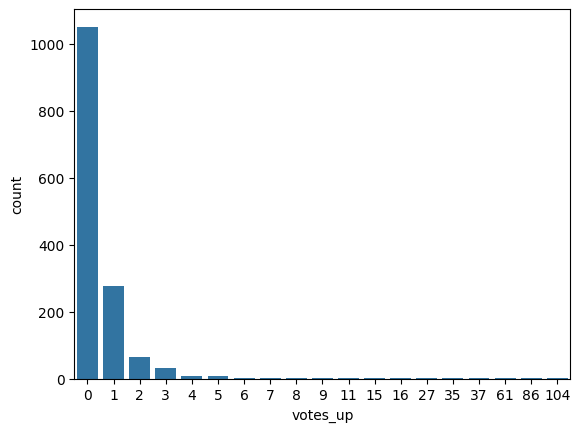

In [9]:
# Show graph for votes up
sns.countplot(x = 'votes_up', data = df)
plt.show()

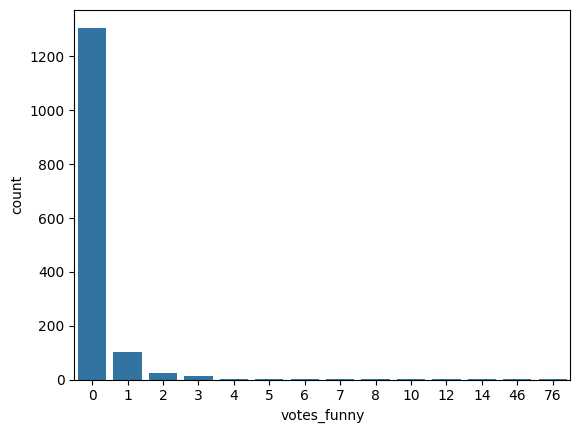

In [10]:
# Show graph for votes funny
sns.countplot(x = 'votes_funny', data = df)
plt.show()

In [11]:
# Use label encoder to map out 0 for not constructive and 1 for constructive (turn categorical column into a numerical column for the model to be able to understand)
label_w = {0: 'Not Constructive', 1: 'Constructive'}
label_counts_w = df['constructive'].value_counts()
print(label_counts_w)

constructive
0    921
1    540
Name: count, dtype: int64


In [12]:
# Use label encoder to map out 0 for false and 1 for true (turn categorical column into a numerical column for the model to be able to understand)
label = {0: 'False', 1: 'True'}
label_counts = df['voted_up'].value_counts()
print(label_counts)

voted_up
True     1206
False     255
Name: count, dtype: int64


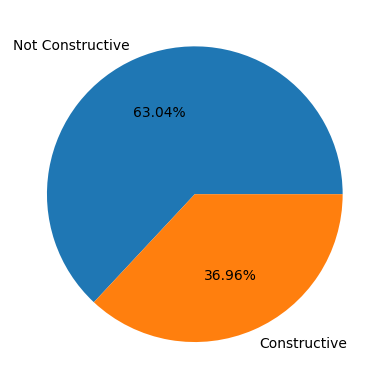

In [13]:
# Show pie chart to decide whether to keep the feature or not (a 80-20 bias should be dropped)
plt.pie(label_counts_w, labels = label_w.values(), autopct = '%.2f%%')
plt.show()

**This pie graph shows in percentage a game is recommended or not. This tells us that there is a huge bias in 'False' (would not recommend) reviews than 'True' (would recommend to other people).**

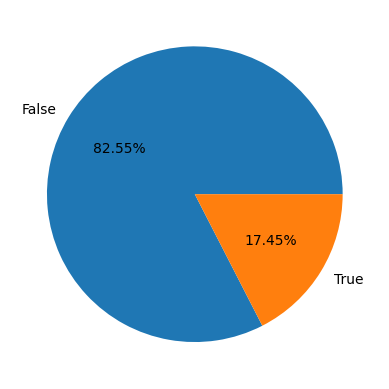

In [14]:
# Show pie chart to decide whether to keep the feature or not (a 80-20 bias should be dropped)
plt.pie(label_counts, labels = label.values(), autopct = '%.2f%%')
plt.show()

**This pie graph shows in percentage if it is constructive and not constructive. This tells us that there will be a bias in determining non constructive reviews than constructive reviews when it is being fed to the model. And with a percentage of 82.55-17.45 it is better to drop the column as the bias is too high and can affect the models ability to predict accurately.**

In [15]:
df.drop(columns='voted_up', axis = 1, inplace = True) # Drop column voted_up

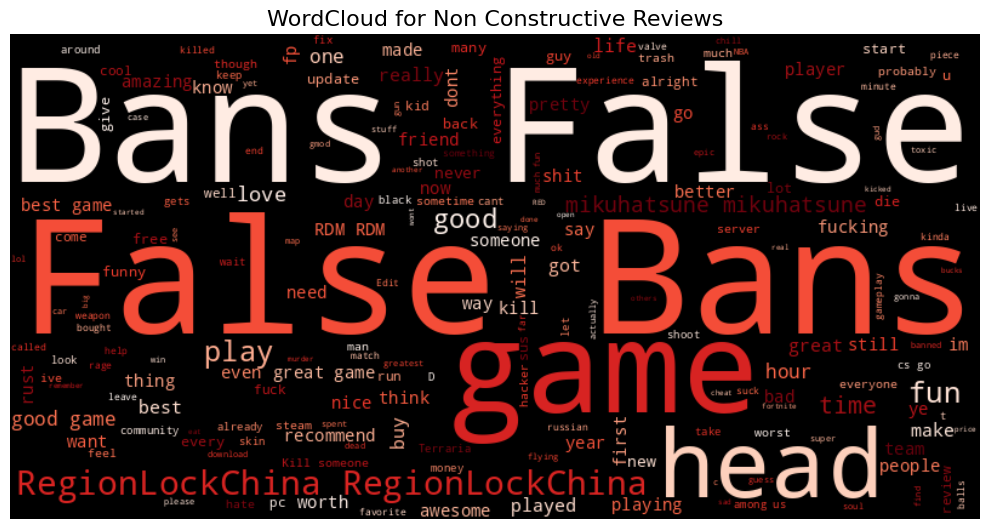

In [16]:
# A wordcloud showing non constructive reviews
from wordcloud import WordCloud

spam_comments = ' '.join(df[df['constructive'] == 0]['review'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_comments)

plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Non Constructive Reviews', fontsize=16)
plt.tight_layout()  # Adjust the layout
plt.show()

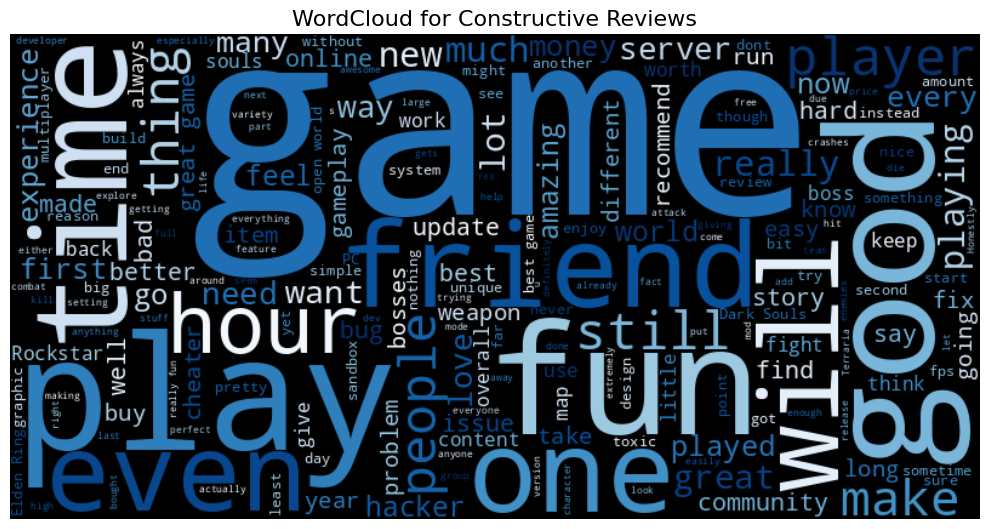

In [17]:
# A wordcloud showing constructive reviews
from wordcloud import WordCloud

spam_comments = ' '.join(df[df['constructive'] == 1]['review'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate(spam_comments)

plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Constructive Reviews', fontsize=16)
plt.tight_layout()  # Adjust the layout
plt.show()

**This graph shows what words are being said the most for non constructive reviews. The more it is said, the bigger the word is in the graph. The most said words in the wordcloud for constructive reviews can be related to being positive such as the words 'good' and 'fun'. While, the wordcloud for non constructive reviews can be related to being negative such as the words 'False' and 'Bans'. Which means that most constructive critisisms has less negative words than non constructive reviews.**

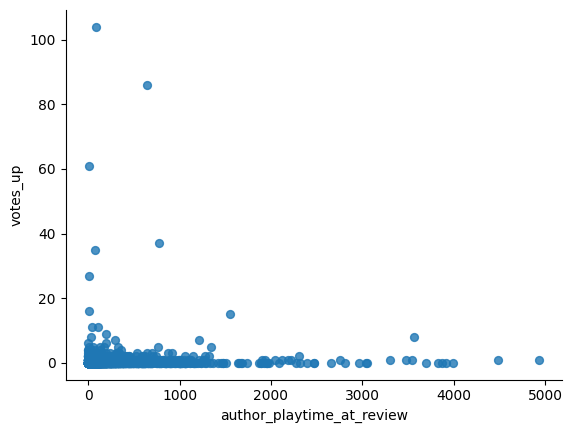

In [18]:
# @title author_playtime_at_review vs votes_up

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='author_playtime_at_review', y='votes_up', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

**This graph checks the relationship between author playtime and votes up. The more the author's playtime goes above 1000 hours does not necessarily mean that their would be a lot of engagement with their reviews. There were a few author who reviewed the game and played for less than 1000 hours that had more votes than those who played more than 1000 hours.**

##copy

In [19]:
# Creating a copy of the dataset to use on different models and with or without special characters
df_sp = df.copy()
df_wo_sp = df.copy()
df_new = df.copy()

In [20]:
display(df_sp)

,game,review,author_playtime_at_review,votes_up,votes_funny,constructive
0,Among Us,This game can suck my balls before I play it a...,6,1,0,0
1,Among Us,Very fun little party game! Even better with f...,11,0,0,1
2,Among Us,if you're lonely don't bother but if you're no...,40,2,1,0
3,Among Us,fun and anoyying,80,0,0,0
4,Among Us,when impostor is sus...,51,0,0,0
...,...,...,...,...,...,...
1456,Tom Clancy's Rainbow Six Siege,Good. Been better in the past.,857,0,0,0
1457,Tom Clancy's Rainbow Six Siege,Great game but man the community is full of 12...,2,0,0,0
1458,Tom Clancy's Rainbow Six Siege,I like smashing skulls in with a sledge hammer,71,0,0,0
1459,Tom Clancy's Rainbow Six Siege,why do i die,78,0,0,0


##RF with special characters

In [21]:
# Concatenate column 'game' and 'review' into a new column called review_info
df_sp['review_info'] = df_sp['game']+' '+df_sp['review']
print(df_sp['review_info'])

0       Among Us This game can suck my balls before I ...
1       Among Us Very fun little party game! Even bett...
2       Among Us if you're lonely don't bother but if ...
3                               Among Us fun and anoyying
4                        Among Us when impostor is sus...
                              ...                        
1456    Tom Clancy's Rainbow Six Siege Good. Been bett...
1457    Tom Clancy's Rainbow Six Siege Great game but ...
1458    Tom Clancy's Rainbow Six Siege I like smashing...
1459          Tom Clancy's Rainbow Six Siege why do i die
1460             Tom Clancy's Rainbow Six Siege lol siege
Name: review_info, Length: 1461, dtype: object


In [22]:
df_sp.drop(['game','review'], axis =1 , inplace = True) # Drop columns 'game' and 'review'

In [23]:
# Create a CountVectorizer instance to convert text data into a matrix of token counts
vectorizer = feature_extraction.text.CountVectorizer()

# Fit the vectorizer on the 'review_info' column and transform it into a sparse matrix
text_vectorized = vectorizer.fit_transform(df_sp['review_info'])

# Convert the sparse matrix to a dense DataFrame with proper column names (tokens/words)
text_df = pd.DataFrame(text_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

# Reset the index of the new text DataFrame to align with the original DataFrame
text_df.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame (without 'review_info') and the new text DataFrame
df_final_sp = pd.concat([df_sp.drop(columns=['review_info']).reset_index(drop=True), text_df], axis=1)

# Print the final DataFrame which now includes tokenized text features
print(df_final_sp)

      author_playtime_at_review  votes_up  votes_funny  constructive  000  \
0                             6         1            0             0    0   
1                            11         0            0             1    0   
2                            40         2            1             0    0   
3                            80         0            0             0    0   
4                            51         0            0             0    0   
...                         ...       ...          ...           ...  ...   
1456                        857         0            0             0    0   
1457                          2         0            0             0    0   
1458                         71         0            0             0    0   
1459                         78         0            0             0    0   
1460                        253         0            0             0    0   

      000000000000000000000000000000000000000  02  0978uhb  0paosdpaosd  \


In [24]:
# Identify features and target
X = df_final_sp.drop(['constructive'], axis = 1)
y = df_final_sp['constructive']
print(X.shape, y.shape)

(1461, 5288) (1461,)


In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 23, stratify = y) # Split the dataset into training(70%) and testing(30%)

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators  = 100, random_state = 12)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=12)

In [27]:
y_pred = rf.predict(X_test)

In [28]:
#Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

#Detailed classification report
print('Classification Report: \n', classification_report(y_test, y_pred, target_names= ['Not Constructive','Constructive']))

#Confusion Matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

Accuracy: 0.7949886104783599
Classification Report: 
                   precision    recall  f1-score   support

Not Constructive       0.78      0.93      0.85       277
    Constructive       0.83      0.56      0.67       162

        accuracy                           0.79       439
       macro avg       0.81      0.75      0.76       439
    weighted avg       0.80      0.79      0.78       439

Confusion Matrix: 
 [[258  19]
 [ 71  91]]


**1. `Not Constructive:`**
- Precision: 0.78

The accuracy rate of predicting the `Not Constructive` is correct 78% of the time.
- Recall: 0.93

The model identifies 93% of all actual `Not Constructive` object correctly.
- F1-Score: 0.85

The model performs well in identifying `Not Constructive`.

**2. `Constructive:`**

- Precision: 0.83

The accuracy rate of predicting the `Constructive`  is correct 85% of the time.
- Recall: 0.56

The model identifies only 53% of all `Constructive`  correctly.

- F1-Score: 0.67

The model does not perform well in predicting the `Constructive`
**Accuracy**

The accuracy of the model is correct 79% of the time.

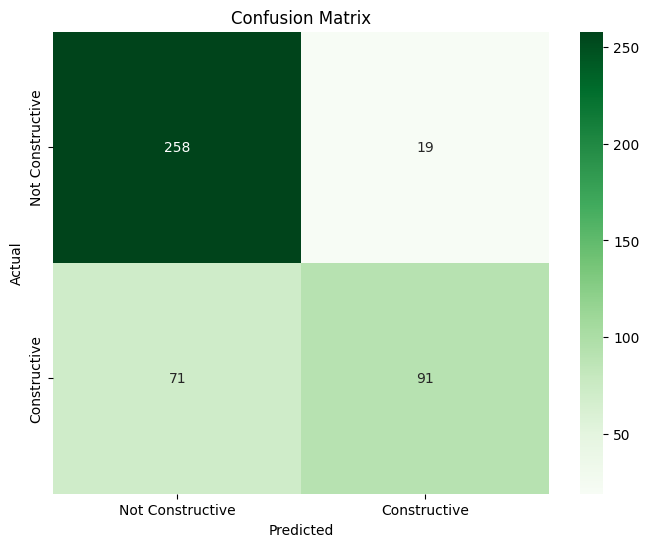

In [29]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = ['Not Constructive','Constructive'], yticklabels = ['Not Constructive','Constructive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- True Negatives

**258** objects are correctly classified as `Not Constructive`.

- False Positives

**19** objects are incorrectly classified as `Constructive` when it should be classified as `Not Constructive`.

- False Negatives

**71** objects are incorrectly classified as `Not Constructive` when it should be classified as `Constructive`

- True Positives

**91** object was correctly classified as `Constructive`

##RF without special characters

In [30]:
# Concatenate column 'game' and 'review' into a new column called review_info
df_wo_sp['review_info'] = df_wo_sp['game']+' '+df_wo_sp['review']
print(df_wo_sp['review_info'])

0       Among Us This game can suck my balls before I ...
1       Among Us Very fun little party game! Even bett...
2       Among Us if you're lonely don't bother but if ...
3                               Among Us fun and anoyying
4                        Among Us when impostor is sus...
                              ...                        
1456    Tom Clancy's Rainbow Six Siege Good. Been bett...
1457    Tom Clancy's Rainbow Six Siege Great game but ...
1458    Tom Clancy's Rainbow Six Siege I like smashing...
1459          Tom Clancy's Rainbow Six Siege why do i die
1460             Tom Clancy's Rainbow Six Siege lol siege
Name: review_info, Length: 1461, dtype: object


In [31]:
df_wo_sp.drop(['game','review'], axis =1 , inplace = True) # Drop columns 'game' and 'review'

In [32]:
df_wo_sp['review_info'] = df_wo_sp['review_info'].str.replace(r'[^a-zA-Z0-9\s]','', regex = True) # Remove special characters

print(df.head())

       game                                             review  \
0  Among Us  This game can suck my balls before I play it a...   
1  Among Us  Very fun little party game! Even better with f...   
2  Among Us  if you're lonely don't bother but if you're no...   
3  Among Us                                   fun and anoyying   
4  Among Us                            when impostor is sus...   

   author_playtime_at_review  votes_up  votes_funny  constructive  
0                          6         1            0             0  
1                         11         0            0             1  
2                         40         2            1             0  
3                         80         0            0             0  
4                         51         0            0             0  


In [33]:
# Create a CountVectorizer to convert text data into a bag-of-words representation
vectorizer = feature_extraction.text.CountVectorizer()

# Fit the vectorizer on the 'review_info' column and transform it into a sparse matrix of word counts
text_vectorized = vectorizer.fit_transform(df_wo_sp['review_info'])

# Convert the sparse matrix to a dense DataFrame with columns named after the words (features)
text_df = pd.DataFrame(text_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

# Reset the index of the new text feature DataFrame to align it with the original DataFrame
text_df.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame (excluding the 'review_info' column) with the new text features
df_final_wsp = pd.concat([df_wo_sp.drop(columns=['review_info']).reset_index(drop=True), text_df], axis=1)

# Print the final DataFrame with original data and extracted text features
print(df_final_wsp)

      author_playtime_at_review  votes_up  votes_funny  constructive  \
0                             6         1            0             0   
1                            11         0            0             1   
2                            40         2            1             0   
3                            80         0            0             0   
4                            51         0            0             0   
...                         ...       ...          ...           ...   
1456                        857         0            0             0   
1457                          2         0            0             0   
1458                         71         0            0             0   
1459                         78         0            0             0   
1460                        253         0            0             0   

      000000000000000000000000000000000000000  010  0978uhb  10  100  1000  \
0                                           0    0       

In [34]:
# Identify features and target
X = df_final_wsp.drop(['constructive'], axis = 1)
y = df_final_wsp['constructive']
print(X.shape, y.shape)

(1461, 5485) (1461,)


In [35]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 23, stratify = y) # Split the dataset into training(70%) and testing(30%)

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators  = 100, random_state = 12)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=12)

In [37]:
y_pred = rf.predict(X_test)

In [38]:
#Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

#Detailed classification report
print('Classification Report: \n', classification_report(y_test, y_pred, target_names= ['Not Constructive','Constructive']))

#Confusion Matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

Accuracy: 0.8041002277904328
Classification Report: 
                   precision    recall  f1-score   support

Not Constructive       0.79      0.94      0.86       277
    Constructive       0.85      0.57      0.68       162

        accuracy                           0.80       439
       macro avg       0.82      0.76      0.77       439
    weighted avg       0.81      0.80      0.79       439

Confusion Matrix: 
 [[260  17]
 [ 69  93]]


**1. `Not Constructive:`**
- Precision: 0.79

The accuracy rate of predicting the `Not Constructive` is correct 78% of the time.
- Recall: 0.94

The model identifies 93% of all actual `Not Constructive` object correctly.
- F1-Score: 0.86

The model performs well in identifying `Not Constructive` patients.

**2. `Constructive:`**

- Precision: 0.85

The accuracy rate of predicting the `Constructive` is correct 82% of the time.
- Recall: 0.57

The model identifies only 56% of all `Constructive`  correctly.
- F1-Score: 0.68

The model does not perform well in predicting the `Constructive`

**Accuracy**

The accuracy of the model is correct 80% of the time.

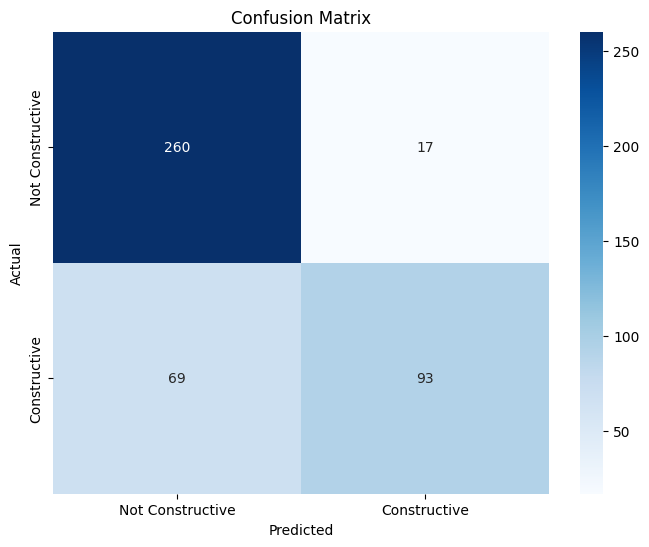

In [39]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Not Constructive','Constructive'], yticklabels = ['Not Constructive','Constructive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- True Negatives

**260** objects are correctly classified as `Not Constructive`.

- False Positives

**17** objects are incorrectly classified as `Constructive` when it should be classified as `Not Constructive`.

- False Negatives

**69** objects are incorrectly classified as `Not Constructive` when it should be classified as `Constructive`

- True Positives

**93** object was correctly classified as `Constructive`

##Bernoulli Naive Bayes

In [40]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
# Concatenate column 'game' and 'review' into a new column called review_info
df_new['review_info'] = df_new['game']+' '+df_new['review']
print(df_new['review_info'])

0       Among Us This game can suck my balls before I ...
1       Among Us Very fun little party game! Even bett...
2       Among Us if you're lonely don't bother but if ...
3                               Among Us fun and anoyying
4                        Among Us when impostor is sus...
                              ...                        
1456    Tom Clancy's Rainbow Six Siege Good. Been bett...
1457    Tom Clancy's Rainbow Six Siege Great game but ...
1458    Tom Clancy's Rainbow Six Siege I like smashing...
1459          Tom Clancy's Rainbow Six Siege why do i die
1460             Tom Clancy's Rainbow Six Siege lol siege
Name: review_info, Length: 1461, dtype: object


In [42]:
df_new.drop(['game','review'], axis =1 , inplace = True) # Drop columns 'game' and 'review'

In [43]:
df_new['review_info'] = df_new['review_info'].str.replace(r'[^a-zA-Z0-9\s]','', regex = True) # Remove special characters

print(df.head())

       game                                             review  \
0  Among Us  This game can suck my balls before I play it a...   
1  Among Us  Very fun little party game! Even better with f...   
2  Among Us  if you're lonely don't bother but if you're no...   
3  Among Us                                   fun and anoyying   
4  Among Us                            when impostor is sus...   

   author_playtime_at_review  votes_up  votes_funny  constructive  
0                          6         1            0             0  
1                         11         0            0             1  
2                         40         2            1             0  
3                         80         0            0             0  
4                         51         0            0             0  


In [44]:
# Import CountVectorizer for converting text data into a bag-of-words representation
vectorizer = feature_extraction.text.CountVectorizer()

# Apply CountVectorizer to the 'review_info' column to transform text into numerical vectors
text_vectorized = vectorizer.fit_transform(df_new['review_info'])

# Convert the sparse matrix output into a dense DataFrame with appropriate column names (i.e., the words)
text_df = pd.DataFrame(text_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

# Reset index to ensure alignment with the original DataFrame
text_df.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame (excluding 'review_info') with the new text features
df_final_new = pd.concat([df_new.drop(columns=['review_info']).reset_index(drop=True), text_df], axis=1)

# Print the resulting DataFrame with the new text-based features included
print(df_final_new)

      author_playtime_at_review  votes_up  votes_funny  constructive  \
0                             6         1            0             0   
1                            11         0            0             1   
2                            40         2            1             0   
3                            80         0            0             0   
4                            51         0            0             0   
...                         ...       ...          ...           ...   
1456                        857         0            0             0   
1457                          2         0            0             0   
1458                         71         0            0             0   
1459                         78         0            0             0   
1460                        253         0            0             0   

      000000000000000000000000000000000000000  010  0978uhb  10  100  1000  \
0                                           0    0       

In [45]:
# Identify features and target
X = df_final_new.drop(['constructive'], axis = 1)
y = df_final_new["constructive"]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21) # Split the dataset into training(70%) and testing(30%)

bnb = BernoulliNB()
model = bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)

In [47]:
#Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

#Detailed classification report
print('Classification Report: \n', classification_report(y_test, y_pred, target_names= ['Not Constructive','Constructive']))

#Confusion Matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

Accuracy: 0.7494305239179955
Classification Report: 
                   precision    recall  f1-score   support

Not Constructive       0.72      0.98      0.83       269
    Constructive       0.92      0.39      0.55       170

        accuracy                           0.75       439
       macro avg       0.82      0.68      0.69       439
    weighted avg       0.79      0.75      0.72       439

Confusion Matrix: 
 [[263   6]
 [104  66]]


**1. `Not Constructive:`**
- Precision: 0.72

The accuracy rate of predicting the `Not Constructive`  is correct 72% of the time.
- Recall: 0.98

The model identifies 98% of all actual `Not Constructive` object correctly.
- F1-Score: 0.83

The model performs well in identifying `Not Constructive`.

**2. `Constructive:`**

- Precision: 0.92

The accuracy rate of predicting the `Constructive`  is correct 92% of the time.
- Recall: 0.39

The model identifies only 39% of all `Constructive`  correctly.

- F1-Score: 0.55

The model does not perform well in predicting the `Constructive`

**Accuracy**

The accuracy of the model is correct 75% of the time.

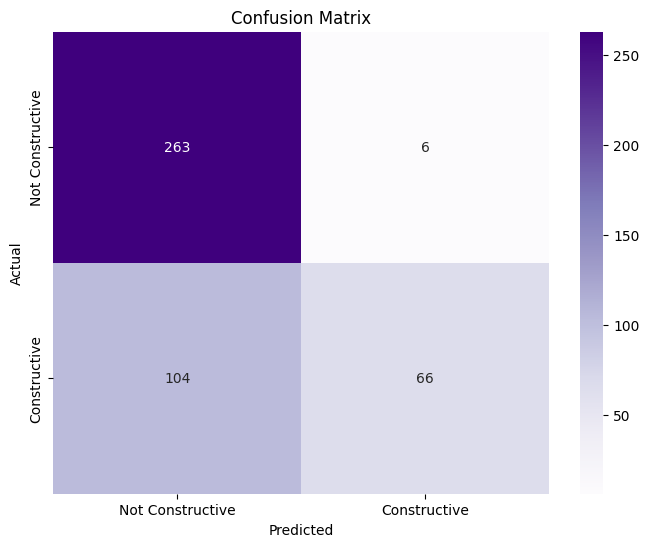

In [48]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Purples', xticklabels = ['Not Constructive','Constructive'], yticklabels = ['Not Constructive','Constructive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- True Negatives

**263** objects are correctly classified as `Not Constructive`.

- False Positives

**6** objects are incorrectly classified as `Constructive` when it should be classified as `Not Constructive`.

- False Negatives

**104** objects are incorrectly classified as `Not Constructive` when it should be classified as `Constructive`

- True Positives

**66** object was correctly classified as `Constructive`